# Liver analysis

**Author**: Alma Andersson<br>
**Description**:<br>

Joint spatial analysis of the entire dataset. The analysis is separated into three parts

- Data Loading and processing
- Feature by distance analysis
- Classification of structures

### Data loading and processing
A brief section loading and processing the data.


### Feature by distance analysis
Here, expression as a function of distance (_feature by distance_) is exemplified, as well as the slightly modified variant where the log-ratio between distances to two different structure classes (here portal and central veins) is examined.


### Classification
This section illustrates how the type of a vein can be predicted based on its neighborhood expression profile (NEP). Included in the analysis is the creation of NEPs, a two step procedure where a neighborhood is first identified, from which a weighted gene expression (by distance) is then assembled. Once the NEPs are formed, a _logistic regression_ model is trained to predict vein type based on the NEP. Cross validation is also implemented to assess performance.


<hr>

### Load libraries

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [14]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import hepaquery as hq
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt
from matplotlib import rcParams

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

from hepaquery.structures import VeinData, Model
import hepaquery.visual as viz
import hepaquery.utils as ut

import re
import datetime

from typing import Tuple


In [3]:
print(hq.__path__)

['/Users/franziskahildebrandt/.local/lib/python3.8/site-packages/hepaquery-0.0.1-py3.8.egg/hepaquery']


In [4]:
rcParams["figure.facecolor"] = "white"

### Global Variables

Here certain global variables are set, which will be used to save output and load data. A brief explanation is provided below:

- TAG : Unique identifier for the analysis. All results will be saved in a folder called "TAG-analysis" within the res-folder.
- REPO\_DIR : Path to the repository directory, only change this if files are moved around.
- DATA_DIR : Path to the data being loaded.
- GENE_LIST_DIR : Directory to lists of genes
- SCALE_FACTOR : Scaling factor between pixels to $\mu m$

In [15]:

TAG = re.sub(":| |-|\\.|","",str(datetime.datetime.today()))
TAG = TAG + "-analysis-spp"

REPO_DIR = osp.dirname(osp.abspath(os.getcwd()))
DATA_DIR = osp.join("/Users/franziskahildebrandt/Desktop/PhDprojectFranziskaHildebrandt/ST-liver/uninfectedLiver-sequenced/ankarliver/data/h5ad-cca")
RESULTS_DIR = osp.join(REPO_DIR,"res/bivariate_res/ans_4",TAG)

if not osp.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
    
GENE_LIST_DIR = osp.join(REPO_DIR,"data/gene-lists/ans_4")


SCALE_FACTOR = 2.8

SAVE_RESULTS = True


In [6]:
# Get data paths
PTHS = list(filter(lambda x: x.endswith("h5ad"),os.listdir(DATA_DIR)))
PTHS = {p:osp.join(DATA_DIR,p) for p in PTHS }

data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}
new_names = {k:d.uns["sample"] + "-" + d.uns["replicate"] for k,d in data_set.items()}
data_set = dict((new_names[k],d) for k,d in data_set.items())
    
data_set

{'CN65-E1': AnnData object with n_obs × n_vars = 590 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-C1': AnnData object with n_obs × n_vars = 647 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-E1': AnnData object with n_obs × n_vars = 1348 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-E2': AnnData object with n_obs × n_vars = 650 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 's

In [7]:
exclude = ["CN65-C1","CN65-C2","CN16-D1", "CN16-E1"]

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN65-E1': AnnData object with n_obs × n_vars = 590 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-E2': AnnData object with n_obs × n_vars = 650 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-D2': AnnData object with n_obs × n_vars = 487 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sa

In [16]:
genes = ut.load_genelist(GENE_LIST_DIR,
                         filter_tag = "Spp",
                        )

In [17]:
genes

{'Spp1': ['Spp1'], 'all': ['Spp1']}

Visualize the data to make sure everything looks as expected

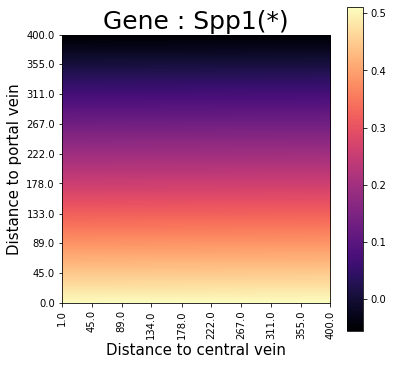

In [18]:
n_genes = len(genes["all"])

fig,ax  = viz.get_figure(n_elements=n_genes,n_cols = 5,side_size=5)

ax = ax.flatten()
alpha = 0.05

likelihoods = dict()

plt_idx = 0
for ii,gene in enumerate(genes["all"]):
    ys = []
    xs = []
    THRS = 143
    
    for k,data in enumerate(data_set.values()):
        if not gene in data.var.index.values:
            continue
        _y = data.obs_vector(gene)
        _x = data.obsm["vein_distances"][["dist_type_central","dist_type_portal"]].values
        keep = np.max(_x,axis=1) < THRS
        _x = _x[keep,:]
        _y = _y[keep]
        ys.append(_y)
        xs.append(_x)

    if len(xs)> 0:
        ys = np.concatenate(ys)
        xs = np.concatenate(xs,axis=0)
        xs = np.hstack((np.ones((xs.shape[0],1)),xs))

        ll = viz.bivariate_expression_plot(ax[plt_idx],
                                           data = [xs,ys],
                                           feature = gene,
                                           feature_name = "Gene",
                                           cmap = plt.cm.magma,
                                           distance_scale_factor = 2.8,
                                          )
        
        likelihoods[gene] = ll
        plt_idx += 1
    
fig.tight_layout()
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"feature-by-distance-ratio.svg"),
                facecolor = "white", dpi = 600)

## Likelihood ratio test

If we have a _full model_ and one _reduced model_, where the second is nested in the former we can conduct a so called likelihood ratio test (LRT) to determine whether the full model significantly improves the model or not (if not we use the simpler model).<br>
<br>
The LRT is executed as follows:<br>
<br>
Let $\mathcal{L}_{reduced}$ and $\mathcal{L}_{full}$ be the likelihood values of each model, and let:<br>
<br>
\begin{equation}
    D = -2\times \log(\frac{\mathcal{L}_{reduced}}{\mathcal{L}_{full}})
\end{equation}

then $D \sim \mathcal{X}^2(\delta)$ where $\delta$ is the number the difference in number of parameters between the full and reduced model.<br>
<br>
By computing the CDF for a given value $D$ and subtracting this from 1, we get the probability of observing a value equally large or more extreme (p-value). If the p-value is below a certain significance threshold $\alpha$ we use the full model does a better job explaining the data (accounting for the extra parameters). <br>
<br>
In this example we test two reduced models, one where the portal respectively central distance is removed. Whenever we get a p-value larger than $\alpha$ this means that the covariate (distance) that we removed did not add to the reduced model.<br>
<br>
Source : https://www.itl.nist.gov/div898/handbook/apr/section2/apr233.htm

In [11]:
likelihoods


{'Hsd11b1': array([-168.83181243, -178.38193909, -177.31436719]),
 'Ly6e': array([-578.23977685, -583.80882075, -579.20622452]),
 'Fgfr2': array([-254.88037274, -255.64625152, -254.9045114 ]),
 'Rspo3': array([-70.36631966, -71.32776032, -80.11368227]),
 'Lifr': array([-483.59842281, -487.43952699, -486.11744982]),
 'Dcn': array([-551.29545849, -552.13056255, -552.84158347])}

In [12]:
model_eval = ut.likelihood_ratio_test(likelihoods,
                                      dofs = [1,1,2],
                                      included_covariates=["central","portal"."intercept"],
                                     )

if SAVE_RESULTS:
    model_eval.to_csv(osp.join(RESULTS_DIR,"likelihood-ratio-test-results.tsv"),
                      sep = "\t",
                     )
    

In [13]:
model_eval

,covariates_central,covariates_portal,[full_model]_superior_to_[central_model],[full_model]_superior_to_[portal_model]
Hsd11b1,0.000012,0.000038,True,True
Ly6e,0.000846,0.164442,True,False
Fgfr2,0.215849,0.826088,False,False
Rspo3,0.165539,0.000010,False,True
Lifr,0.005577,0.024796,True,True
Dcn,0.196231,0.078666,False,False
